In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from torch.optim import AdamW

# --- MappingNet (EncResistant) ---

class EncResistantDDPM(nn.Module):
    """Mapping network that projects weights to watermark space."""
    def __init__(self, weight_size, watermark_len, expansion_factor=2):
        super().__init__()
        self.fc1 = nn.Linear(weight_size, 100, bias=True)
        self.fc2 = nn.Linear(100, expansion_factor * weight_size, bias=True)
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        # Secret projection matrix
        self.register_buffer(
            "matrix_a",
            torch.randn(weight_size * expansion_factor, watermark_len)
        )

    def forward(self, theta_f):
        out = self.fc1(theta_f)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.sig(out @ self.matrix_a)
        return out


# --- Classe Principale Res_Encrypt ---

class ResEncryptDDPM:
    def __init__(self, model_id, device="cuda"):
        self.device = device
        self.model_id = model_id

        # Chargement du modele
        self.pipeline = DDPMPipeline.from_pretrained(model_id)
        self.unet = self.pipeline.unet.to(device)
        self.scheduler = self.pipeline.scheduler

        # Configuration par defaut
        self.config = {
            "layer_name": "mid_block.resnets.0.conv1.weight",  # Couche cible
            "watermark_len": 32,
            "expansion_factor": 10,
            "lr": 1e-4,
            "lr_mn": 1e-3,  # Learning rate for MappingNet
            "lambda_1": 1.0,   # Watermark loss weight
            "lambda_2": 0.1,   # Original watermark loss weight
            "lambda_3": 0.001, # L1 regularization weight
            "epochs": 30,
        }

        self.saved_keys = {}

    def _get_target_weights(self, model):
        """Recupere le tenseur des poids de la couche cible."""
        for name, param in model.named_parameters():
            if name == self.config["layer_name"]:
                return param
        raise ValueError(f"Parametre {self.config['layer_name']} introuvable.")

    def _get_mean(self, weights):
        """Compute mean based on layer type."""
        if len(weights.shape) == 4:  # Conv layer
            return weights.mean(dim=(0, 1))
        elif len(weights.shape) == 2:  # Linear layer
            return weights.mean(dim=0)
        else:
            raise NotImplementedError("Layer type not supported")

    def embed(self, dataloader):
        """
        Incorpore la marque Res_Encrypt pendant le finetuning.
        Utilise un MappingNet pour projeter les poids vers l'espace du watermark.
        """
        print(f"--- Demarrage Embedding Res_Encrypt ({self.config['layer_name']}) ---")

        # 1. Preparation des modeles
        original_unet = deepcopy(self.unet)
        original_unet.eval()
        for p in original_unet.parameters():
            p.requires_grad = False

        watermarked_unet = self.unet
        watermarked_unet.train()

        # 2. Generation des Cles
        target_weights = self._get_target_weights(watermarked_unet)
        with torch.no_grad():
            theta_f = torch.flatten(self._get_mean(target_weights))
            weight_size = len(theta_f)

        print(f"Dimension vecteur poids : {weight_size} | Watermark : {self.config['watermark_len']} bits")

        # Watermarks
        watermark_target = torch.randint(0, 2, (self.config["watermark_len"],)).float().to(self.device)
        watermark_random = torch.randint(0, 2, (self.config["watermark_len"],)).float().to(self.device)

        # MappingNet
        mapping_net = EncResistantDDPM(
            weight_size,
            self.config["watermark_len"],
            self.config["expansion_factor"]
        ).to(self.device)

        # Original weights (frozen)
        orig_weights = self._get_target_weights(original_unet)
        theta_fn = torch.flatten(self._get_mean(orig_weights)).detach()

        # 3. Optimiseur (UNet + MappingNet)
        optimizer = torch.optim.AdamW([
            {'params': watermarked_unet.parameters(), 'lr': self.config["lr"]},
            {'params': mapping_net.parameters(), 'lr': self.config["lr_mn"]}
        ])

        mse_loss = nn.MSELoss()
        bce_loss = nn.BCELoss()

        # 4. Boucle d'entrainement
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(dataloader)
            for clean_images, _ in pbar:
                clean_images = clean_images.to(self.device)
                bs = clean_images.shape[0]

                # A. Processus de Diffusion (Forward)
                noise = torch.randn_like(clean_images).to(self.device)
                timesteps = torch.randint(0, self.scheduler.config.num_train_timesteps, (bs,), device=self.device).long()
                noisy_images = self.scheduler.add_noise(clean_images, noise, timesteps)

                optimizer.zero_grad()

                # B. Prediction (Task Loss)
                noise_pred = watermarked_unet(noisy_images, timesteps).sample
                l_main = mse_loss(noise_pred, noise)

                # C. Watermark Losses (Res_Encrypt)
                current_weights = self._get_target_weights(watermarked_unet)
                theta_f = torch.flatten(self._get_mean(current_weights))

                # Projection via MappingNet
                matrix_g = mapping_net(theta_f.unsqueeze(0)).squeeze(0)
                matrix_gn = mapping_net(theta_fn.unsqueeze(0)).squeeze(0)

                # Loss: watermarked model -> target watermark
                l_wat = bce_loss(matrix_g, watermark_target)
                # Loss: original model -> random watermark (discriminative)
                l_wat_orig = bce_loss(matrix_gn, watermark_random)
                # L1 regularization on weights
                l_l1_w = torch.norm(theta_f, p=1)

                # Loss Totale
                l_total = (l_main +
                          self.config["lambda_1"] * l_wat +
                          self.config["lambda_2"] * l_wat_orig +
                          self.config["lambda_3"] * l_l1_w)

                l_total.backward()
                optimizer.step()

                # Metrics
                ber = self._compute_ber(matrix_g, watermark_target)
                pbar.set_description(
                    f"Epoch {epoch+1} | L_Main: {l_main:.3f} | L_Wat: {l_wat:.3f} | "
                    f"L_Orig: {l_wat_orig:.3f} | BER: {ber:.2f}"
                )

                # if ber == 0.0 and l_wat.item() < 0.01:
                #     print("Convergence atteinte !")
                #     break
            # if ber == 0.0:
            #     break

        # Sauvegarde des cles
        self.saved_keys = {
            "watermark_target": watermark_target,
            "watermarked_unet": watermarked_unet,
            "mapping_net": mapping_net,
            "original_unet": original_unet,
        }
        return watermarked_unet

    def extract(self, suspect_unet=None):
        """
        Extrait la marque d'un modele suspect via le MappingNet.
        """
        if suspect_unet is None:
            suspect_unet = self.saved_keys["watermarked_unet"]

        mapping_net = self.saved_keys["mapping_net"]
        watermark_target = self.saved_keys["watermark_target"]

        mapping_net.eval()

        # 1. Recuperation des poids
        try:
            target_weights = self._get_target_weights(suspect_unet)
        except ValueError:
            print("Couche cible introuvable dans le modele suspect.")
            return 1.0, None

        # 2. Projection via MappingNet
        with torch.no_grad():
            theta_f = torch.flatten(self._get_mean(target_weights))
            pred_wm_prob = mapping_net(theta_f.unsqueeze(0)).squeeze(0)
            ber = self._compute_ber(pred_wm_prob, watermark_target)

        print(f"BER Extrait : {ber:.2f}")
        return ber, pred_wm_prob

    @staticmethod
    def _compute_ber(pred, target):
        return ((pred > 0.5).float() != target).float().mean().item()


In [10]:
# --- EXEMPLE D'EXECUTION ---

# 1. Setup Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 2. Embedding Res_Encrypt
res_encrypt_defense = ResEncryptDDPM("google/ddpm-cifar10-32")
watermarked_model = res_encrypt_defense.embed(dataloader)

In [11]:
# 3. Extraction (Test immediat)
ber, _ = res_encrypt_defense.extract(watermarked_model)
print(f"\nResultat final - BER: {ber:.2f}")

BER Extrait : 0.00

Resultat final - BER: 0.00


In [19]:
# --- Fonction de Distillation (Attaque) ---

def run_distillation_attack_res_encrypt(res_obj, dataloader, epochs=5, lr=1e-4):
    """
    Tente de transferer la fonctionnalite du modele Res_Encrypt vers un modele vierge.
    Verifie si la marque (basee sur les poids + MappingNet) survit.
    """
    device = res_obj.device

    # 1. Teacher (Gele)
    teacher_unet = res_obj.saved_keys["watermarked_unet"]
    teacher_unet.eval()
    for p in teacher_unet.parameters():
        p.requires_grad = False

    # 2. Student (Vierge - Meme architecture)
    print("\n--- Initialisation du Student ---")
    student_pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")
    student_unet = student_pipeline.unet.to(device)
    student_unet.train()

    teacher_ber, _ = res_obj.extract(teacher_unet)
    student_ber, _ = res_obj.extract(student_unet)
    # Sanity Checks
    print(f"[Check] BER Teacher: {teacher_ber:.2f}")
    print(f"[Check] BER Student (Avant): {student_ber:.2f}")

    optimizer = AdamW(student_unet.parameters(), lr=lr)
    noise_scheduler = res_obj.scheduler
    history = {"loss": [], "ber": []}

    print(f"\n--- Distillation Res_Encrypt ({epochs} epochs) ---")

    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0

        for clean_images, _ in pbar:
            clean_images = clean_images.to(device)
            bs = clean_images.shape[0]

            # A. Input Noise
            noise = torch.randn_like(clean_images).to(device)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # B. Distillation (Output Matching)
            with torch.no_grad():
                target_pred = teacher_unet(noisy_images, timesteps).sample

            student_pred = student_unet(noisy_images, timesteps).sample

            loss = F.mse_loss(student_pred, target_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(Loss=loss.item())

        # C. Verification : Est-ce que les poids se sont alignes ?
        current_ber, pred_wm_prob = res_obj.extract(student_unet)
        history["ber"].append(current_ber)
        history["loss"].append(running_loss / len(dataloader))

        err_wat = nn.BCELoss()(pred_wm_prob, res_obj.saved_keys["watermark_target"]) if pred_wm_prob is not None else float('nan')
        print(f"Fin Epoch {epoch+1} | Loss: {history['loss'][-1]:.4f} | BER Student: {current_ber:.2f} | err_wat: {err_wat:.4f}")

    return student_unet, history


In [ ]:
# 4. Attaque par Distillation
student_res, stats = run_distillation_attack_res_encrypt(res_encrypt_defense, dataloader, epochs=1000)

Epoch 241:  68%|██████▊   | 528/782 [01:47<00:51,  4.97it/s, Loss=0.000124]

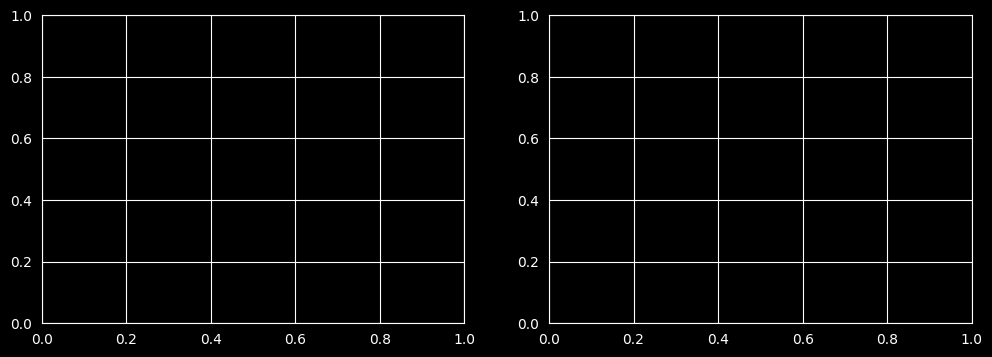

In [1]:
# 5. Visualisation des resultats
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(stats["loss"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Distillation Loss")

ax2.plot(stats["ber"])
ax2.axhline(y=0.5, color='r', linestyle='--', label='Random (0.5)')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("BER")
ax2.set_title("BER Evolution During Distillation")
ax2.legend()

plt.tight_layout()
plt.show()